In [1]:
import os
import tensorflow as tf
from model import Model
from tensorflow.python.keras import layers, losses
import matplotlib.pyplot as plt

# Data location:

In [2]:
data_location = "../data/split"
export_location = "../models/"

model_prefix = ["", "formula-", "name-"][1]
first_category = ["formula", "inorganic"][1]
second_category = ["name", "organic"][1]

model_name = model_prefix + first_category + "-" + second_category

In [3]:
dataset_directory = os.path.join(data_location, model_name)
train_directory = os.path.join(dataset_directory, "train")
test_directory = os.path.join(dataset_directory, "test")

print("In data:", os.listdir(dataset_directory))
print("In train:", os.listdir(train_directory))
print("In test:", os.listdir(test_directory))

In data: ['test', 'train']
In train: ['inorganic', 'inorganic-90%.txt', 'organic', 'organic-90%.txt']
In test: ['inorganic', 'inorganic-10%.txt', 'organic', 'organic-10%.txt']


### Sample file:

In [4]:
sample_file = os.path.join(train_directory, first_category, "ab.txt")

print("Sample file:", open(sample_file).read())

Sample file: DyCl3



# Data collection:

In [5]:
seed = 32  # Random seed for data shuffling and transformations
validation_split = 0.2  # Proportion of train data used to validate the model

In [6]:
raw_train_data_source = tf.keras.preprocessing.text_dataset_from_directory(
    train_directory,
    subset="training",
    seed=seed,
    validation_split=validation_split,
)

Found 18710 files belonging to 2 classes.
Using 14968 files for training.


In [7]:
raw_validation_data_source = tf.keras.preprocessing.text_dataset_from_directory(
    train_directory,
    subset="validation",
    seed=seed,
    validation_split=validation_split,
)

Found 18710 files belonging to 2 classes.
Using 3742 files for validation.


In [8]:
raw_test_data_source = tf.keras.preprocessing.text_dataset_from_directory(
    test_directory,
)

Found 2078 files belonging to 2 classes.


# Data pre-processing:

In [9]:
max_features = 2048  # Sets a boundary for len(vectorize_layer.get_vocabulary())

In [10]:
sequence_length = 16  # Vectorized string's dimension

vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    output_mode="int",
    max_tokens=max_features,
    standardize=Model.data_standardization,
    output_sequence_length=sequence_length
)

In [11]:
# Makes a text-only dataset (without labels), then calls adapt
train_text = raw_train_data_source.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [12]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [13]:
# Retrieves a batch of 32 reviews and labels from the dataset
text_batch, label_batch = next(iter(raw_train_data_source))
first_review, first_label = text_batch[0], label_batch[0]

print("Review:", first_review)
print("Label:", raw_train_data_source.class_names[first_label])
print("Vectorized review:", vectorize_text(first_review, first_label))

Review: tf.Tensor(b'CH3-O-CH(CH3)-CHF-CH2(NO2)\r\n', shape=(), dtype=string)
Label: organic
Vectorized review: (<tf.Tensor: shape=(1, 16), dtype=int64, numpy=array([[2, 3, 9, 4, 8, 4, 2, 3, 6, 2, 3, 9, 5, 4, 2, 3]], dtype=int64)>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)


In [14]:
print("Vocabulary size:", len(vectorize_layer.get_vocabulary()))

Vocabulary size: 42


In [15]:
print("Vocabulary:", sorted(vectorize_layer.get_vocabulary(), key=len))

Vocabulary: ['', 'c', 'h', '-', ')', '(', '2', 'o', '3', 'n', '=', 'b', 'r', 'i', 'l', 'f', '≡', 's', '4', 'a', 'e', 't', 'p', 'm', 'u', 'g', '5', '1', '6', 'd', 'v', 'z', '7', '8', 'k', 'w', '0', 'y', '9', '+', 'x', '[UNK]']


In [16]:
train_data_source = raw_train_data_source.map(vectorize_text)
validation_data_source = raw_validation_data_source.map(vectorize_text)
test_data_source = raw_test_data_source.map(vectorize_text)

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # ??

train_data_source = train_data_source.cache().prefetch(buffer_size=AUTOTUNE)
validation_data_source = validation_data_source.cache().prefetch(buffer_size=AUTOTUNE)
test_data_source = test_data_source.cache().prefetch(buffer_size=AUTOTUNE)

# Model creation:

In [18]:
model = Model(
    max_features=max_features,
    embedding_dim=1024,  # 1024 seems to be optimal, 16 was default
)

### Training:

In [19]:
history = model.get().fit(
    epochs=5,
    x=train_data_source,
    validation_data=validation_data_source,
)

Epoch 1/5
468/468 [==============================] - 26s 54ms/step - loss: 0.0385 - binary_accuracy: 0.9890 - val_loss: 0.0109 - val_binary_accuracy: 0.9955
Epoch 2/5
468/468 [==============================] - 17s 37ms/step - loss: 0.0098 - binary_accuracy: 0.9962 - val_loss: 0.0077 - val_binary_accuracy: 0.9968
Epoch 3/5
468/468 [==============================] - 16s 35ms/step - loss: 0.0088 - binary_accuracy: 0.9961 - val_loss: 0.0057 - val_binary_accuracy: 0.9976
Epoch 4/5
468/468 [==============================] - 18s 38ms/step - loss: 0.0078 - binary_accuracy: 0.9968 - val_loss: 0.0064 - val_binary_accuracy: 0.9968
Epoch 5/5
468/468 [==============================] - 17s 36ms/step - loss: 0.0077 - binary_accuracy: 0.9971 - val_loss: 0.0056 - val_binary_accuracy: 0.9979


### Compiling:

In [20]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model.get(),
    layers.Activation("sigmoid")
])

export_model.compile(
    optimizer="adam",
    metrics=["accuracy"],
    loss=losses.BinaryCrossentropy(from_logits=False),
)

# Model evaluation:

### Using test data:

In [21]:
loss, accuracy = model.get().evaluate(test_data_source)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

65/65 [==============================] - 1s 12ms/step - loss: 0.0057 - binary_accuracy: 0.9986
Test loss: 0.005684389732778072
Test accuracy: 0.9985563158988953


### Using raw test data:

In [22]:
loss, accuracy = export_model.evaluate(raw_test_data_source)

print("Raw test loss:", loss)
print("Raw test accuracy:", accuracy)

65/65 [==============================] - 1s 12ms/step - loss: 0.0057 - accuracy: 0.9986
Raw test loss: 0.005684391129761934
Raw test accuracy: 0.9985563158988953


### Accuracy graph:

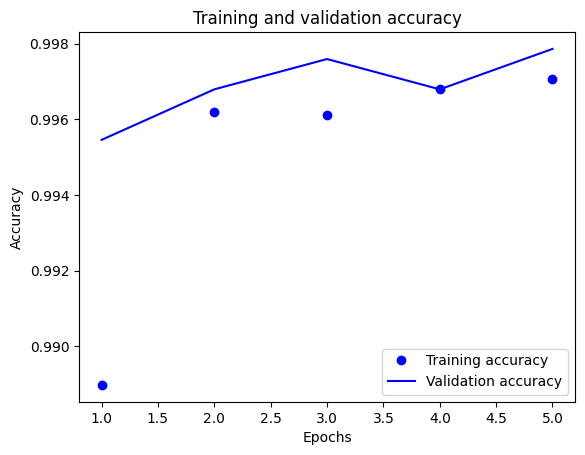

In [23]:
history_dict = history.history
history_dict.keys()

accuracy = history_dict["binary_accuracy"]
validation_accuracy = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
validation_loss = history_dict["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")  # Blue dots
plt.plot(epochs, validation_accuracy, "b", label="Validation accuracy")  # Blue line
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()

### Loss graph:

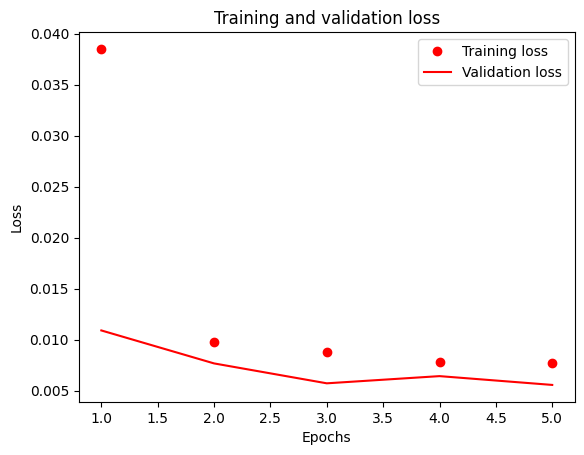

In [24]:
plt.plot(epochs, loss, "ro", label="Training loss")  # Red dots
plt.plot(epochs, validation_loss, "r", label="Validation loss")  # Red line
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Model exportation:

In [25]:
export_model.save(export_location + model_name + "-model", save_format='tf')

INFO:tensorflow:Assets written to: ../models/formula-inorganic-organic-model\assets


INFO:tensorflow:Assets written to: ../models/formula-inorganic-organic-model\assets


# Model predictions:

In [26]:
def predict(examples):
    for example in examples:
        prediction = export_model.predict([example])[0][0] * 100
        category = first_category if prediction < 50 else second_category
        print(category, "(" + "%.2f" % prediction + "%):", example)

### Inorganic formulas:

In [27]:
inorganic_formulas = [
    "mn2(Hpo3)3",
    "NaCl",
    "H2SO4",
    "CL203",
    "znCO2",
    "H2O",
    "FeNA2",
    "G2S2O5",
    "Cl2O⁺H2O",
]

predict(inorganic_formulas)

1/1 [==============================] - 0s 118ms/step
inorganic (0.00%): mn2(Hpo3)3
1/1 [==============================] - 0s 37ms/step
inorganic (0.00%): NaCl
1/1 [==============================] - 0s 34ms/step
inorganic (0.00%): H2SO4
1/1 [==============================] - 0s 33ms/step
inorganic (1.12%): CL203
1/1 [==============================] - 0s 38ms/step
inorganic (0.04%): znCO2
1/1 [==============================] - 0s 37ms/step
inorganic (0.32%): H2O
1/1 [==============================] - 0s 41ms/step
inorganic (0.00%): FeNA2
1/1 [==============================] - 0s 36ms/step
inorganic (0.00%): G2S2O5
1/1 [==============================] - 0s 41ms/step
inorganic (0.27%): Cl2O⁺H2O


### Inorganic names:

In [28]:
inorganic_names = [
    "arsenito diacido de sodio",
    "hipoclorito de sodio",
    "potasiuro de boro",
    "cloruro de sodio",
    "acido disulfuroso",
    "sulfurico",
]

predict(inorganic_names)

1/1 [==============================] - 0s 41ms/step
inorganic (0.00%): arsenito diacido de sodio
1/1 [==============================] - 0s 38ms/step
inorganic (0.00%): hipoclorito de sodio
1/1 [==============================] - 0s 39ms/step
inorganic (0.00%): potasiuro de boro
1/1 [==============================] - 0s 38ms/step
inorganic (0.00%): cloruro de sodio
1/1 [==============================] - 0s 38ms/step
inorganic (0.00%): acido disulfuroso
1/1 [==============================] - 0s 40ms/step
inorganic (0.00%): sulfurico


### Organic formulas:

In [29]:
organic_formulas = [
    "Ch3ChCh(Ch3ChCh3)ChCh",
    "H3C-CH2",
    "H3C-CH2-CH2",
    "h c c h",
    "h c c h h c c h",
    "CH3-CO-O-CH2-CH3",
    "CH3-CH2-O-CH2-CH3",
    "CH3-CH2-CH=CH-COOH",
    "ch3chch2ch(ch2ch2ch3)cooh",
    "ch3(Ch3)Chch2Ch(Ch3)Ch2Ch(Ch2Ch2Ch3)Ch3",
]

predict(organic_formulas)

1/1 [==============================] - 0s 34ms/step
organic (100.00%): Ch3ChCh(Ch3ChCh3)ChCh
1/1 [==============================] - 0s 40ms/step
organic (100.00%): H3C-CH2
1/1 [==============================] - 0s 36ms/step
organic (100.00%): H3C-CH2-CH2
1/1 [==============================] - 0s 34ms/step
organic (100.00%): h c c h
1/1 [==============================] - 0s 37ms/step
organic (100.00%): h c c h h c c h
1/1 [==============================] - 0s 35ms/step
organic (100.00%): CH3-CO-O-CH2-CH3
1/1 [==============================] - 0s 71ms/step
organic (100.00%): CH3-CH2-O-CH2-CH3
1/1 [==============================] - 0s 54ms/step
organic (100.00%): CH3-CH2-CH=CH-COOH
1/1 [==============================] - 0s 56ms/step
organic (100.00%): ch3chch2ch(ch2ch2ch3)cooh
1/1 [==============================] - 0s 44ms/step
organic (100.00%): ch3(Ch3)Chch2Ch(Ch3)Ch2Ch(Ch2Ch2Ch3)Ch3


### Organic names:

In [30]:
organic_names = [
    "arsano",
    "benceno",
    "naftaleno",
    "2-cloropentanato",
    "cloruro de propilo",
    "di 2-cloropentanil éter",
    "2-bromo-2-cloropropano",
    "metanoato de isopropilo",
    "orto-difenilciclohexano",
    "2-bromo-2-cloropropil yododecil éter",
    "3-cloro-2-fluoro-hexa-1,3-dien-5-in-1-ona",
    "4-amino-2,6,6-tricloro-7,7-difluoro-89-metil-3-nitro-1,1-diyodononaconta-1,3-dien-5-ona",
]

predict(organic_names)

1/1 [==============================] - 0s 39ms/step
inorganic (0.00%): arsano
1/1 [==============================] - 0s 54ms/step
inorganic (0.00%): benceno
1/1 [==============================] - 0s 44ms/step
inorganic (0.00%): naftaleno
1/1 [==============================] - 0s 52ms/step
inorganic (0.00%): 2-cloropentanato
1/1 [==============================] - 0s 47ms/step
inorganic (0.00%): cloruro de propilo
1/1 [==============================] - 0s 45ms/step
inorganic (0.00%): di 2-cloropentanil éter
1/1 [==============================] - 0s 48ms/step
inorganic (0.00%): 2-bromo-2-cloropropano
1/1 [==============================] - 0s 44ms/step
inorganic (0.00%): metanoato de isopropilo
1/1 [==============================] - 0s 41ms/step
inorganic (0.00%): orto-difenilciclohexano
1/1 [==============================] - 0s 41ms/step
inorganic (0.00%): 2-bromo-2-cloropropil yododecil éter
1/1 [==============================] - 0s 40ms/step
inorganic (0.00%): 3-cloro-2-fluoro-hexa-1,3-